In [1]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GroupKFold
import joblib

from sklearn.metrics import r2_score, mean_squared_error
from tool_kit import calc_ccc, accuracy_plot
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# # model parameters
# import json
# with open('/mnt/inca/soc_eu_model/data/006_params_annual.json', 'r') as file:
#     params = json.load(file)

# train
folder = '/mnt/inca/soc_eu_model'
df = pd.read_csv(f'{folder}/data_history/005.0_train.pnts_soc.csv',low_memory=False)
# target
train = df.loc[df['oc'].notna()]
train = train.loc[train['oc']>5]
train = train.loc[train['ref']!='nl.bis'] # show weird patterns
train.loc[:,'oc_log1p'] = np.log1p(train['oc'])
tgt = 'oc_log1p'

# test
dff = pd.read_csv(f'{folder}/data_history/004.0_validate.pnts_soc.csv',low_memory=False)
# target
test = dff.loc[dff['oc'].notna()]
test = test.loc[test['oc']>5]
test = test.loc[test['ref']!='nl.bis'] # data from nl.bis show weird patterns
test.loc[:,'oc_log1p'] = np.log1p(test['oc'])

# covariates
with open(f'{folder}/SOC-EU/features/002_selected.covar_rank.freq.txt', 'r') as file:
    lines = file.readlines()
covs = [line.strip() for line in lines]
train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')

spatial_cv_column = 'tile_id'
cv = GroupKFold(n_splits=5)

/home/opengeohub/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Parameter fine tuning for random forest

In [2]:

# https://zillow.github.io/quantile-forest/user_guide/fit_predict.html#random-forest-predictions

param_grid = {
    'n_estimators': [200, 500, 800, 1000],
    'max_depth': [10, 20, 30],
    'max_features': [0.3, 0.5, 0.7, 'log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tune_rf = HalvingGridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=90, 
    cv=cv,
    verbose=1
)

ttprint(f'start parameter fine tuning for rf, training size: {len(train)}')
tune_rf.fit(train[covs], train[tgt], groups=train[spatial_cv_column])
ttprint("Finish fine tuning\nBest parameters found: ", tune_rf.best_params_)
joblib.dump(tune_rf.best_params_, f'{folder}/SOC-EU/model/001_best.params_rf.joblib')
joblib.dump(tune_rf.best_estimator_, f'{folder}/SOC-EU/model/002_model_rf.joblib')


[08:47:45] start parameter fine tuning for rf, training size: 129109
n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 531
max_resources_: 129109
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 540
n_resources: 531
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
----------
iter: 1
n_candidates: 180
n_resources: 1593
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 2
n_candidates: 60
n_resources: 4779
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 3
n_candidates: 20
n_resources: 14337
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 4
n_candidates: 7
n_resources: 43011
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[11:22:14] Finish fine tuning
Best parameters found:  {'max_depth': 30, 'max_features': 0.3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 800}


['/mnt/inca/soc_eu_model/SOC-EU/model/002_model_rf.joblib']

### test different data

In [2]:
import joblib
from mapie.metrics import regression_coverage_score
from tool_kit import calc_ccc, accuracy_plot
from mapie.regression import MapieQuantileRegressor, MapieRegressor

model_params = joblib.load(f'{folder}/SOC-EU/model/001_best.params_rf.joblib')


[06:19:23] start fitting model
[06:20:43] finish fitting model
[06:20:43] start fitting mapie
[06:27:31] finish fitting mapie


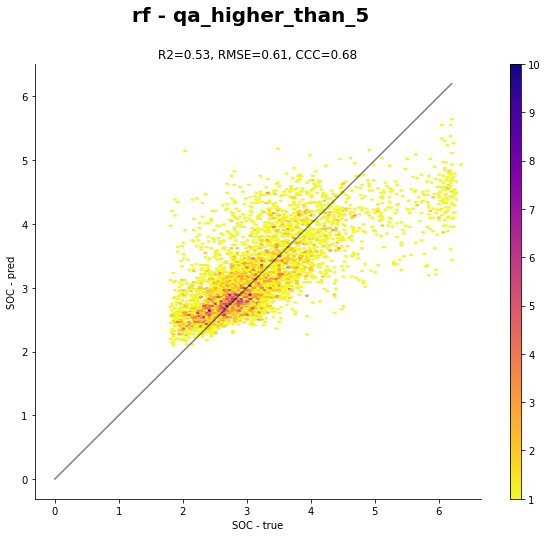

Concordance Correlation Coefficient (CCC): 0.6844
Root Mean Squared Error (RMSE): 0.6057
R-squared (R2): 0.5297
Prediction Interval Coverage Probability (PICP): 0.8654
Prediction Interval Width (PI Width): 1.6461


In [3]:

title = 'qa_higher_than_5'

train_t = train

model = RandomForestRegressor(**model_params, n_jobs=80)
    
ttprint('start fitting model')
model.fit(train_t[covs],train_t[tgt])
ttprint('finish fitting model')
    
ttprint('start fitting mapie')
mapie = MapieRegressor(model, method="plus", cv=5) # this cv is to compute the conformal scores
mapie.fit(train_t[covs], train_t[tgt])
ttprint('finish fitting mapie')
        
joblib.dump(model, f'{folder}/SOC-EU/model/test_rf_{title}.joblib')
joblib.dump(mapie, f'{folder}/SOC-EU/model/test_rf.mapie_{title}.joblib')
        
y_pred, y_pis = mapie.predict(test[covs], alpha=0.1) # 90% prediction interval 
accuracy_plot(test[tgt], y_pred, title_text=f'rf - {title}')

#     y_pred = model.predict(test[covs])
ccc = calc_ccc(test[tgt], y_pred)
rmse = np.sqrt(mean_squared_error(test[tgt], y_pred))
r2 = r2_score(test[tgt], y_pred)
picp = np.mean((test[tgt] >= y_pis[:, 0, 0]) & (test[tgt] <= y_pis[:, 1, 0]))
pi_width = np.mean(y_pis[:, 1, 0] - y_pis[:, 0, 0])

print(f"Concordance Correlation Coefficient (CCC): {ccc:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Prediction Interval Coverage Probability (PICP): {picp:.4f}")
print(f"Prediction Interval Width (PI Width): {pi_width:.4f}")

In [4]:
print(len(train))
print(len(test))

129109
4406
